In [1]:
from calendar import month_name
from typing import Protocol

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR as svr
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error

from category_encoders import BinaryEncoder

plt.style.use('dark_background')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class Model(Protocol):
    def fit(self, X,y, *args, **kwargs): ...
    def transform(self, X,y, *args, **kwargs): ...
    def predict(self, X, *args, **kwargs): ...

In [4]:
# import data
df0 = pd.read_csv('./data/walmart_data.csv')
walmart = df0.copy()

**Dataset info**:

Historical data that covers sales from 2010-02-05 to 2012-11-01, in the Wamart.

**Fields**:

* Store - the store number
* Date - the week of sales
* Weekly_Sales - sales for the given store
* Holiday_Flag - whether the week is a special holiday week 1 – Holiday week 0 – Non-holiday week
* Temperature - Temperature on the day of sale
* Fuel_Price - Cost of fuel in the region
* CPI – Prevailing consumer price index
* Unemployment - Prevailing unemployment rate
* Holiday Events\ Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13\ Labour Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13\ Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13\ Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

#### Data Exploration

In [5]:
walmart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [6]:
walmart.describe().style.background_gradient(cmap = 'YlGnBu')

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1046964.877562,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,564366.622054,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,209986.250000,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,553350.105000,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,960746.040000,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1420158.660000,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3818686.450000,1.000000,100.140000,4.468000,227.232807,14.313000


#### Feature engeenering

In [7]:
# convert values from 'Date' column to datetime format
walmart['Date'] = pd.to_datetime(walmart.Date, yearfirst=True, format='%d-%m-%Y')
walmart['Store'] = walmart['Store'].astype(object)

new_features = [('year','year'), ('month', 'month'), ('week','isocalendar().week')]
for feature, fun in new_features:
    df_name = 'walmart'
    code = f"{df_name}['{feature}'] = {df_name}.Date.dt.{fun}"
    exec(code)

In [8]:
pd.DataFrame.from_dict(
    {col: np.count_nonzero(walmart[col].unique()) for col in 
    ['Holiday_Flag', 'Temperature', 'Fuel_Price', 'Unemployment', 'CPI']}, 
    orient='index', columns=['Frequency'])

,Frequency
Holiday_Flag,1
Temperature,3528
Fuel_Price,892
Unemployment,349
CPI,2145


In [9]:
def get_season(month: int) -> str:
    """
    Helper function for apply on DataFrame object to get season according to month column
    """
    match month:
        case 3|4|5: 
            return 'Spring'
        case 6|7|8:
            return 'Summer'
        case 9|10|11:
            return 'Autumn'
        case _:
            return 'Winter'


In [10]:
walmart['Season'] = walmart['month'].apply(get_season)
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,week,Season
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,2,5,Winter
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,2,6,Winter
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,2,7,Winter
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,2,8,Winter
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,3,9,Spring


#### Exploatory Data Analysis

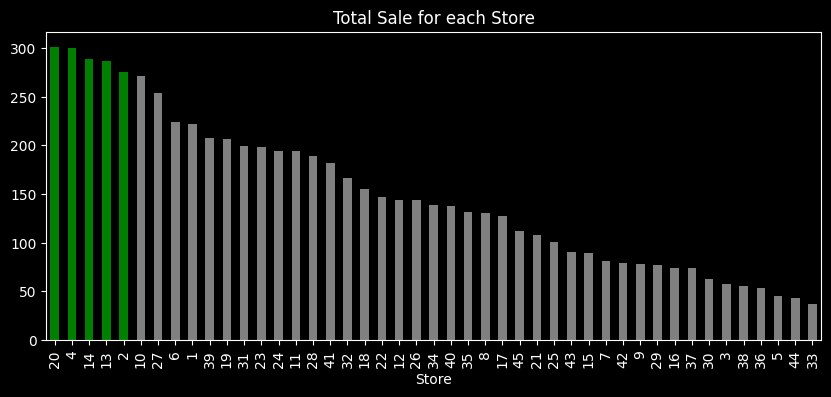

In [11]:
top=len(walmart.Store.unique())
bar_colors = ['gray' if _ > 4 else 'green' for _ in range(top)]
weekly_by_store = walmart.groupby(by=['Store']).agg({'Weekly_Sales':np.sum})\
    .sort_values('Weekly_Sales',ascending=False)['Weekly_Sales']/1e6

ax = weekly_by_store\
        .plot(kind='bar', color=bar_colors, figsize=(10,4), legend=None)
        
ax.set_title("Total Sale for each Store")

plt.show()

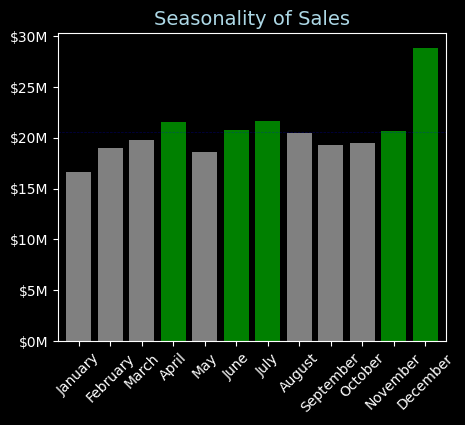

In [12]:
monthly = (walmart.groupby(by=['year','month']).agg({'Weekly_Sales':np.sum})\
    .reset_index().groupby(by=['month'])['Weekly_Sales'].mean()/10e6)
monthly_mean = np.mean(monthly.values.mean())
colors = ['green' if v > monthly_mean else 'grey' for v in monthly.values]
ax=monthly\
        .plot(kind='bar', color=colors, width=0.8, figsize=(5,4))
ax.set_yscale('linear')
ax.set_yticks(list(range(0,35,5)))
ax.set_yticklabels([f'${v}M' for v in range(0,35,5)])
months = [m for m in month_name if len(m)>0]
ax.set_xticklabels(months,rotation = 45)
ax.axhline(monthly_mean, linestyle='--', color='blue', alpha=0.3, linewidth=0.5)
ax.set_title('Seasonality of Sales', fontdict={'fontsize':14, 'color':'lightblue'})
ax.set_xlabel(None)
plt.show()

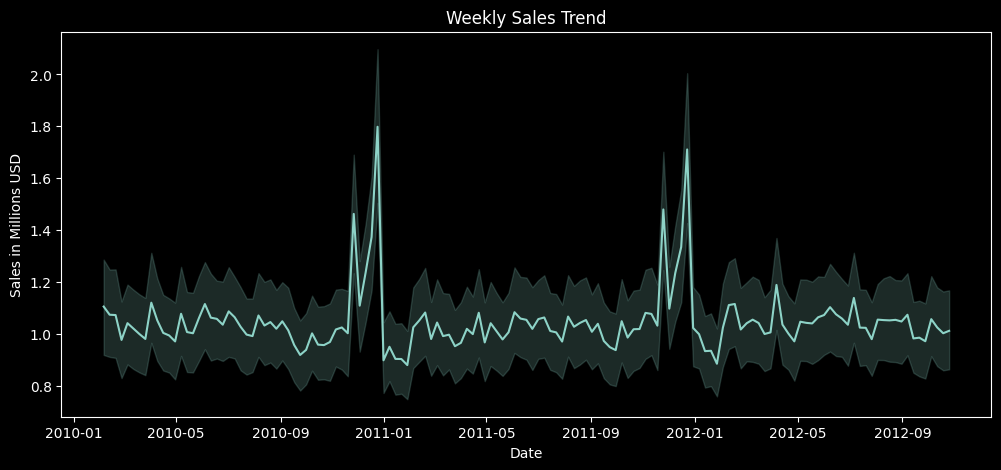

In [13]:
plt.figure(figsize=(12,5))
ax = sns.lineplot(x=walmart.Date, y=walmart.Weekly_Sales/1e6)
ax.set_ylabel("Sales in Millions USD")
ax.set_xlabel("Date")
ax.set_title("Weekly Sales Trend")
plt.show()

#### Univariate anlysis

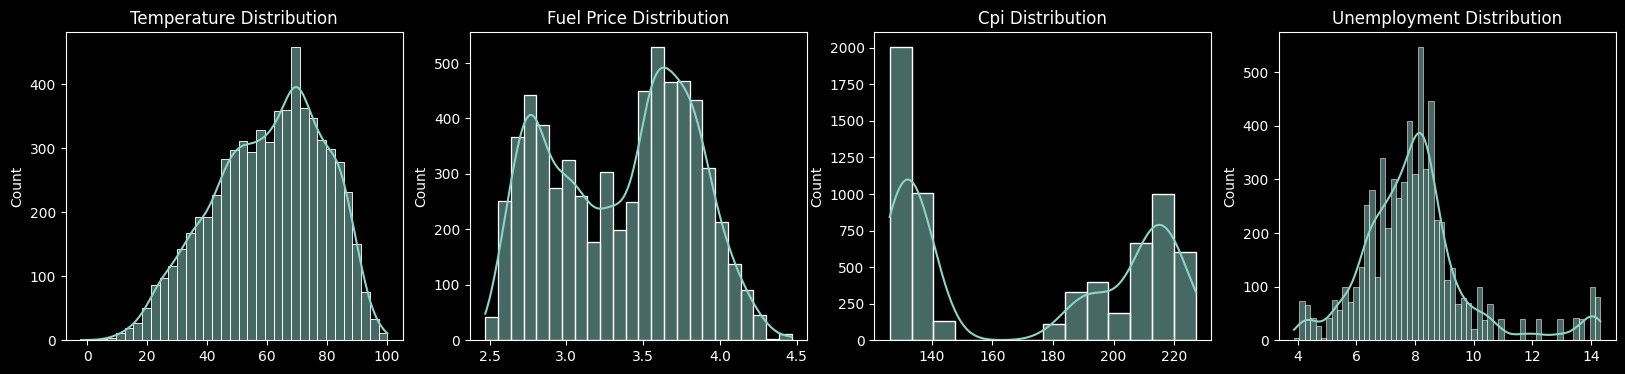

In [14]:
fig, ax = plt.subplots(1,4, figsize=(20,4))
cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
for i, feature in enumerate(cols):
    sns.histplot(walmart[feature], kde=True, ax=ax[i])
    ax[i].set_title(f"{feature.replace('_',' ').title()} Distribution")
    ax[i].set_xlabel(None)
plt.show()

`CPI` and `Fuel_Price` have bi modal distribution.

`Temperature` and `Uneployment` have approximately normal distribution

#### Outliers detect

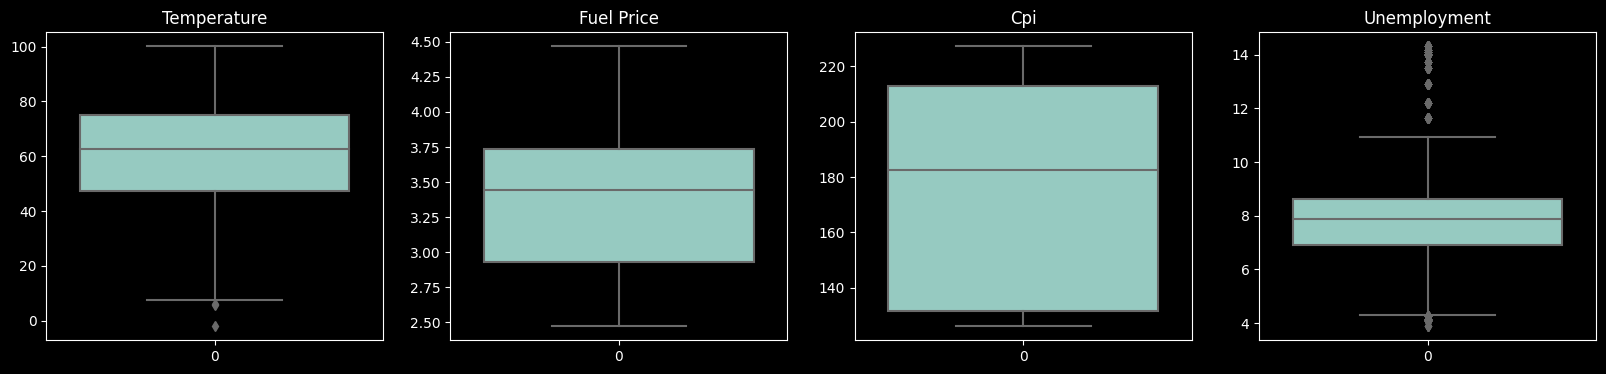

In [15]:
fig, ax = plt.subplots(1,4, figsize=(20,4))
for i, feature in enumerate(cols):
    sns.boxplot(walmart[feature], ax=ax[i])
    ax[i].set_title(f"{feature.replace('_',' ').title()}")
plt.show()

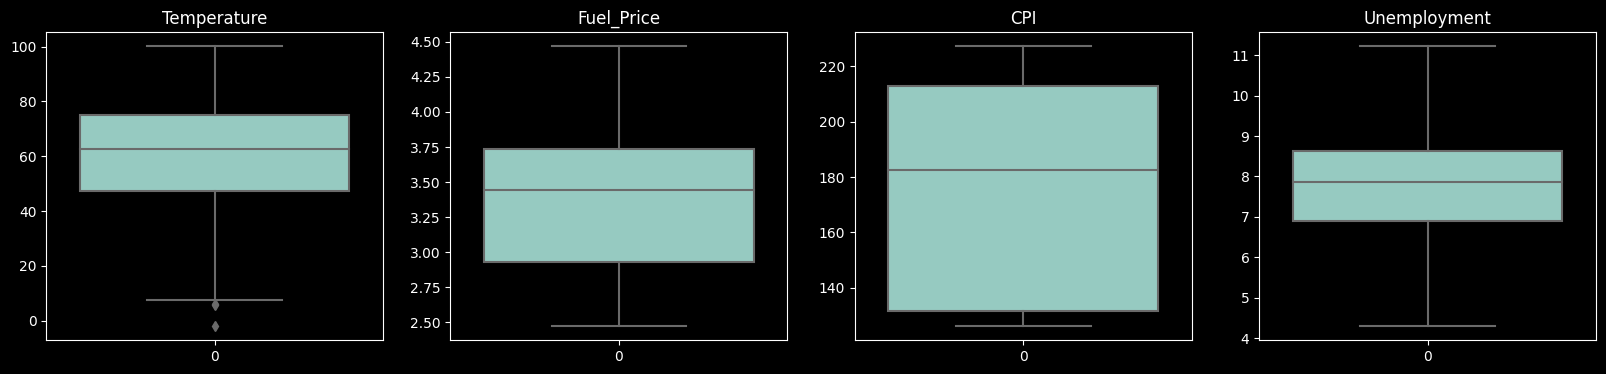

In [16]:
# handling outliers in `Unemployment`
q25 = walmart.Unemployment.quantile(0.25)
q75 = walmart.Unemployment.quantile(0.75)
iqr = q75 - q25
l_limit = q25 - iqr * 1.5
u_limit = q75 + iqr * 1.5
walmart.loc[walmart.Unemployment < l_limit, 'Unemployment'] = l_limit
walmart.loc[walmart.Unemployment > u_limit, 'Unemployment'] = u_limit

fig, ax = plt.subplots(1,4, figsize=(20,4))
for i, feature in enumerate(cols):
    sns.boxplot(walmart[feature], ax=ax[i])
    ax[i].set_title(feature)
plt.show()


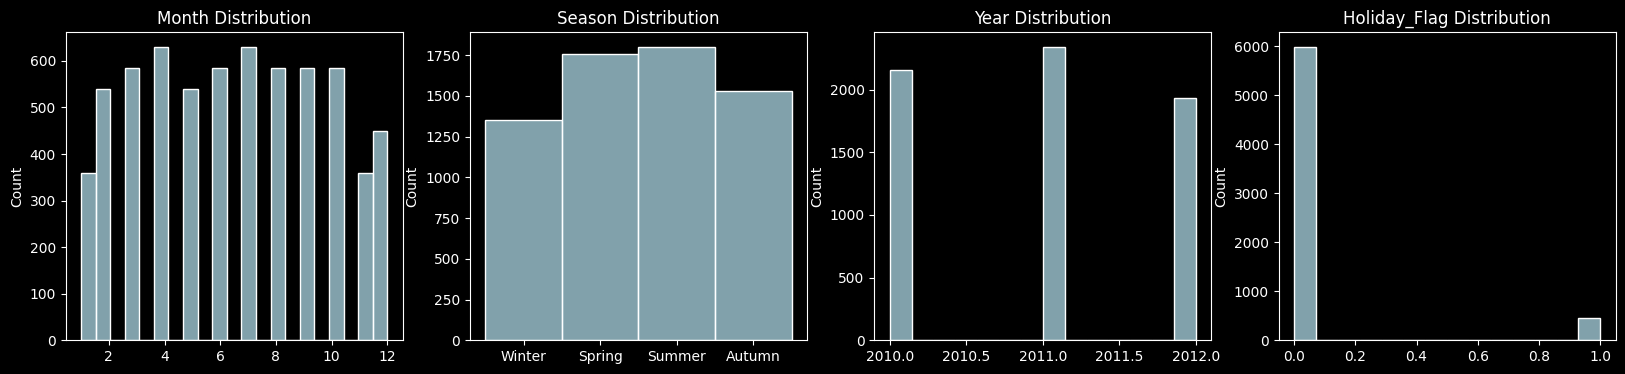

In [17]:
cols = ['month', 'Season', 'year', 'Holiday_Flag']
fig, ax = plt.subplots(1,4, figsize=(20,4))
for i, feature in enumerate(cols):
    sns.histplot(walmart[feature], color='lightblue', ax=ax[i])
    ax[i].set_title(f"{feature.title()} Distribution")
    ax[i].set_xlabel(None)

plt.show()

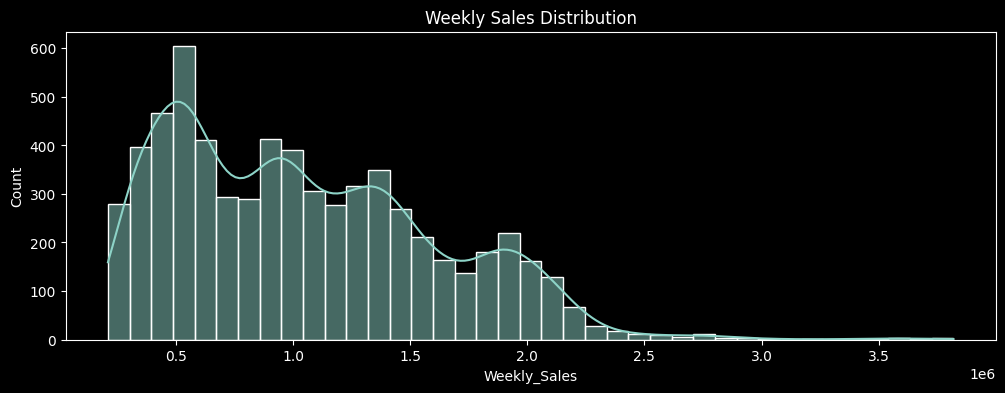

In [18]:
# Weakly Sales distribution
fig, ax = plt.subplots(figsize = (12,4))
sns.histplot(data=walmart, x='Weekly_Sales', kde=True, ax=ax)
ax.set_title('Weekly Sales Distribution')
plt.show()

#### Bivariate analysis

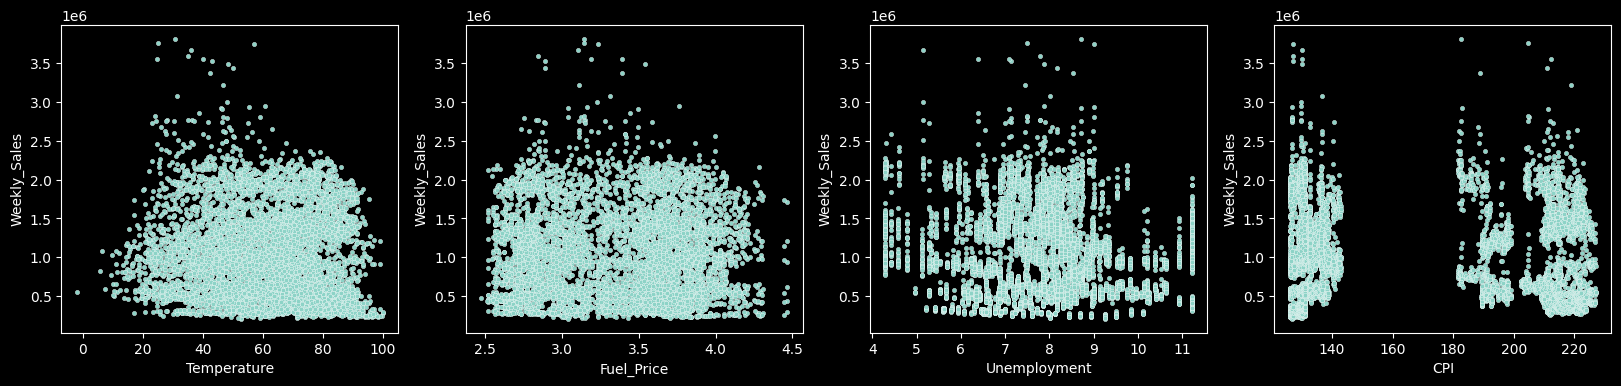

In [19]:
cols = ['Temperature', 'Fuel_Price', 'Unemployment', 'CPI']
fig, ax = plt.subplots(1,4, figsize=(20,4))
for i, feature in enumerate(cols):
    sns.scatterplot(data=walmart, y='Weekly_Sales', x=feature, s=10, ax=ax[i])

plt.show()

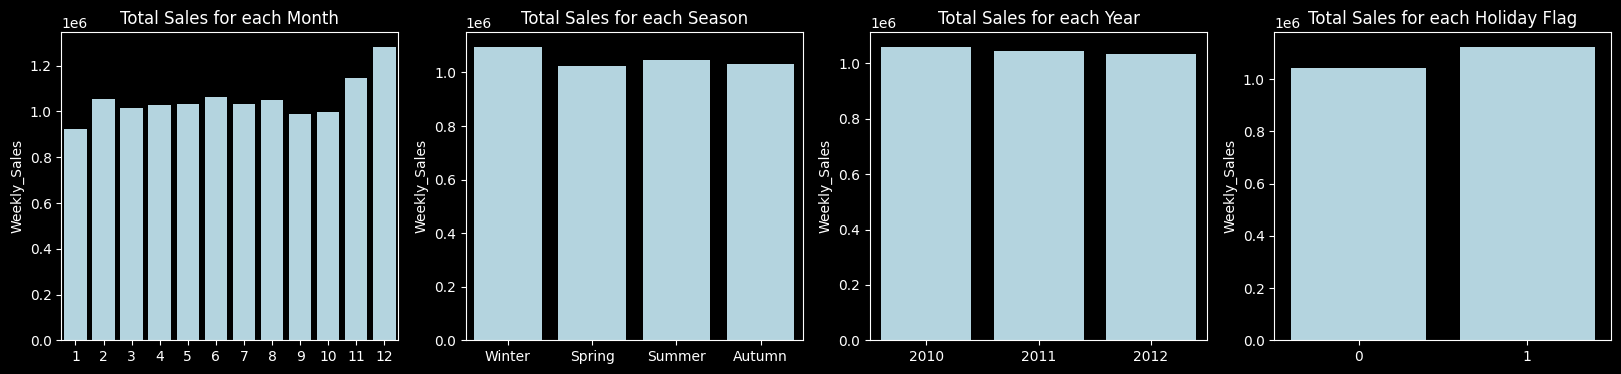

In [20]:
# Total Sales for each feature
cols = ["month", "Season", "year", "Holiday_Flag"]
fig, ax = plt.subplots(1,4, figsize=(20,4))
for i, feature in enumerate(cols):
    sns.barplot(data=walmart, x=feature, y='Weekly_Sales', color='lightblue', 
                errorbar=None, ax=ax[i])
    ax[i].set_xlabel(None)
    ax[i].set_title(f"Total Sales for each {feature.replace('_',' ').title()}")
    ax[i]
plt.show()


In [21]:
monthly_sale = (walmart.pivot_table(index='month', values='Weekly_Sales', columns='year', aggfunc=np.mean)/1e6)\
    .round(2)
monthly_sale

year,2010,2011,2012
month,,,
1,NaN,0.91,0.94
2,1.06,1.04,1.07
3,1.01,1.00,1.03
4,1.03,1.01,1.05
5,1.04,1.01,1.05
6,1.07,1.05,1.07
7,1.03,1.02,1.04
8,1.04,1.05,1.05
9,0.98,0.98,1.00


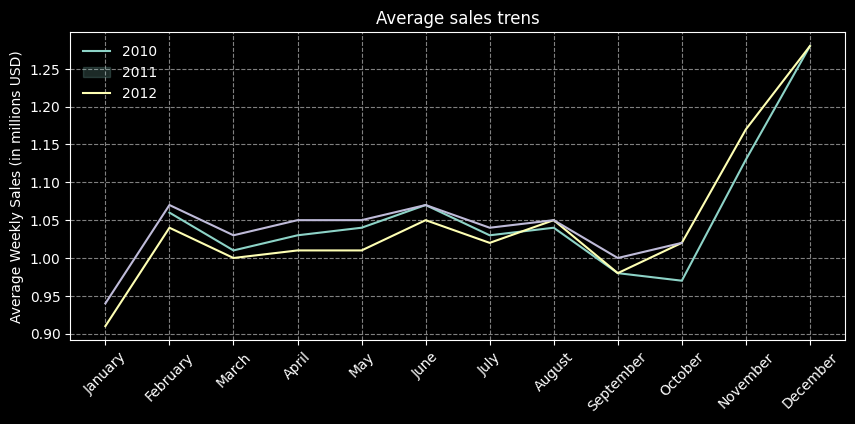

In [22]:
# plot sekes level for each year
plt.figure(figsize=(10,4))
sns.lineplot(x=monthly_sale.index, y=monthly_sale[2010])
sns.lineplot(x=monthly_sale.index, y=monthly_sale[2011])
sns.lineplot(x=monthly_sale.index, y=monthly_sale[2012])
plt.xticks(list(range(1,13)),labels=list(month_name[1:]), rotation=45)
plt.ylabel('Average Weekly Sales (in millions USD)')
plt.xlabel(None)
plt.title('Average sales trens')
plt.legend(['2010','2011','2012'], frameon=False)
plt.grid(color='grey', linestyle='--')
plt.show()

In [23]:
# select id stores with five bigest sale amount
top_5_stores = (walmart.groupby(by=['Store']).agg({'Weekly_Sales':np.sum})/1e6).round(2)\
    .reset_index().rename(columns={'Weekly_Sales':'all_time_sale', 'Store':'store_id'})\
        .sort_values(by=['all_time_sale'], ascending=False).reset_index(drop=True).iloc[:5,:]
top_5_stores


,store_id,all_time_sale
0,20,301.40
1,4,299.54
2,14,289.00
3,13,286.52
4,2,275.38


In [24]:
non_holidays_sales = walmart.query('Holiday_Flag == 0')['Weekly_Sales']/1e6
holidays_sales = walmart.query('Holiday_Flag == 1')['Weekly_Sales']/1e6
non_holidays_sales.shape, holidays_sales.shape

((5985,), (450,))

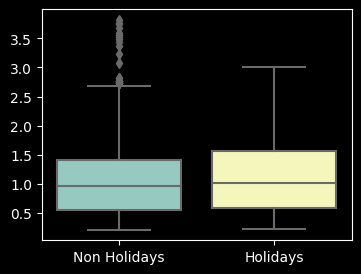

In [25]:
fig,ax = plt.subplots(figsize=(4,3))
sns.boxplot(data = [non_holidays_sales.values, holidays_sales.values], ax=ax)
ax.set_xticklabels(labels=['Non Holidays', 'Holidays'])
plt.show()

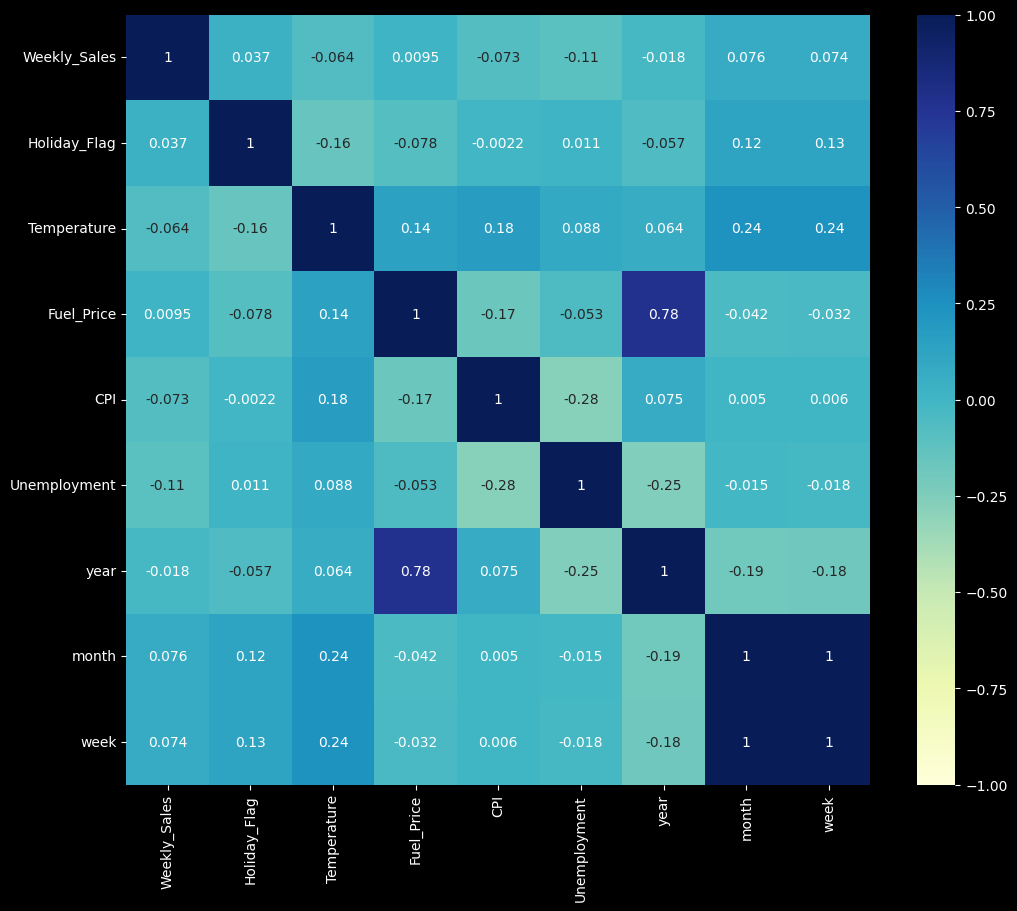

In [26]:
variable_corr = walmart.corr(numeric_only=True)
fig,heatmap = plt.subplots(figsize=(12,10))
sns.heatmap(variable_corr, annot=True, vmin=-1, vmax=1, cmap ="YlGnBu", ax=heatmap)

plt.show()

### Model building

In [27]:
X = walmart.copy()
X.drop(columns=['Date'], inplace=True)
y = X.pop('Weekly_Sales')
X = BinaryEncoder(cols=['Store', 'Season']).fit_transform(X)
stratify_col = [idx for idx, col in enumerate(X.columns) if col == 'week'][0]
print(X.columns)
X = StandardScaler().fit_transform(X)

Index(['Store_0', 'Store_1', 'Store_2', 'Store_3', 'Store_4', 'Store_5',
       'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'year', 'month', 'week', 'Season_0', 'Season_1', 'Season_2'],
      dtype='object')


In [28]:
X_tr, X_test, y_tr, y_test = train_test_split(X,y, stratify=X[:,stratify_col], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.2)
X_train.shape[0], X_val.shape[0], X_test.shape[0]

(4118, 1030, 1287)

In [29]:
regressors = {'Linear Regression':{'model':make_pipeline(PolynomialFeatures(degree=3), LinearRegression()),
                                   'params': {'polynomialfeatures__degree':[2,3,4]},
                                   },
              'Ridge Regression':{'model':make_pipeline(PolynomialFeatures(), Ridge()),
                                  'params': {'polynomialfeatures__degree':[2,3,4],
                                             'ridge__alpha':[1,10, 100,1000]},
                                  },
              'Lasso Regression':{'model':make_pipeline(PolynomialFeatures(), Lasso()),
                                  'params': {'polynomialfeatures__degree':[2,3,4],
                                             'lasso__alpha':[1000, 2000],
                                             'lasso__max_iter':[300, 500]}
                                  },
              # 'Elastic Net Regression': ElasticNet(),
              # 'Decision Tree Regression': DecisionTreeRegressor(),
              'Random Forest Regression': {'model': RandomForestRegressor(),
                                           'params': {'criterion':['squared_error', 'absolute_error'],
                                                      'max_depth': [3,4,7],
                                                      'max_features': [.3,.4,.7]}
                                           },
              # 'Boosted Tree Regression': GradientBoostingRegressor(),
              # 'Neural Network Regression': MLPRegressor(),
              # 'Support Vector Regression': svr()
            }


In [30]:
def evaluate_models(regressors: dict[str,dict[str, Model | dict]],  X_train, y_train, X_val, y_val,**kwargs)-> dict[str,tuple]:
    """
    Function return a dictionary of tuned regression models
    """
    best_estimators: dict[str,tuple[Model,float]] = {}
    if 'scoring' in kwargs.keys():
        _scoring = kwargs.get('scoring')
    else:
        _scoring  = {'r2', 'max_error', 'neg_root_mean_squared_error'}
    if 'cv' in kwargs.keys():
        _cv = kwargs.get('cv')
    else:
        _cv=5
    if 'refit' in kwargs.keys():
        _refit = kwargs.get('refit')
    else:
        _refit = 'r2'

    for regressor in regressors:
        _model = regressors[regressor].get('model')
        _params = regressors[regressor].get('params')
        searcher = GridSearchCV(_model, param_grid=_params, scoring=_scoring, cv=_cv, refit=_refit)
        searcher.fit(X_train, y_train)
        test_score = searcher.score(X_val, y_val)
        y_pred = searcher.best_estimator_.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        best_estimators[regressor] = (searcher.best_estimator_, searcher.best_score_, rmse, test_score)
    return best_estimators

In [31]:
best_estimators = evaluate_models(regressors, X_train, y_train, X_val, y_val)
estimators_rank = pd.DataFrame.from_dict(best_estimators, orient='index', columns=['Model', 'Avg train R2', 'RMSE','Val R2'])\
    .sort_values(by=['Val R2'], ascending=False)
estimators_rank.RMSE = estimators_rank.RMSE.astype(int)

In [32]:
estimators_rank

,Model,Avg train R2,RMSE,Val R2
Lasso Regression,"(PolynomialFeatures(degree=4), Lasso(alpha=100...",0.968189,85043,0.973712
Ridge Regression,"(PolynomialFeatures(degree=3), Ridge(alpha=1))",0.966892,94747,0.967371
Linear Regression,"(PolynomialFeatures(degree=3), LinearRegressio...",0.966110,95473,0.966869
Random Forest Regression,(DecisionTreeRegressor(criterion='absolute_err...,0.899655,149298,0.918982


In [37]:
#testing champion model
champion_model_score = estimators_rank.iloc[0,0].score(X_test, y_test)
champion_model_name = estimators_rank.index[0]
champion_pred = estimators_rank.iloc[0,0].predict(X_test)
champion_rmse = (mean_squared_error(y_test, champion_pred))**0.5
champion_residuals = y_test - champion_pred
print(champion_model_name, 'R2:', champion_model_score)
print(champion_model_name, 'RMSE:', champion_rmse)


Lasso Regression R2: 0.9661301163572998
Lasso Regression RMSE: 106161.28438425675


In [38]:
import statsmodels.api as sm

### Checking normality assumption


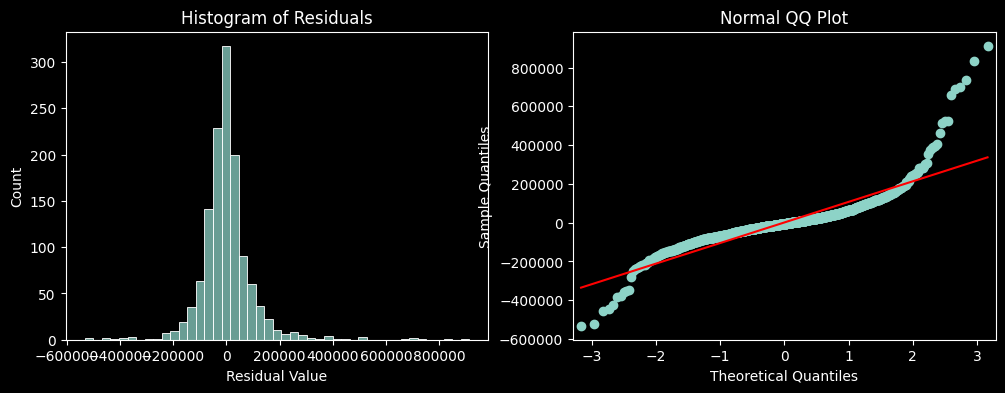

In [45]:
fig, axes = plt.subplots(1,2, figsize = (12,4))
# create a histogram wih the residuals
sns.histplot(champion_residuals, bins=45,ax=axes[0])

axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")

# create a Q-Q plot of the residuals
sm.qqplot(champion_residuals, line='s', ax=axes[1])

axes[1].set_title("Normal QQ Plot")

plt.show()

The histogram of residuals are approximately normaly distributed, wtich supports that the normality assumption is met for this model.


### Checking constang variance assumption

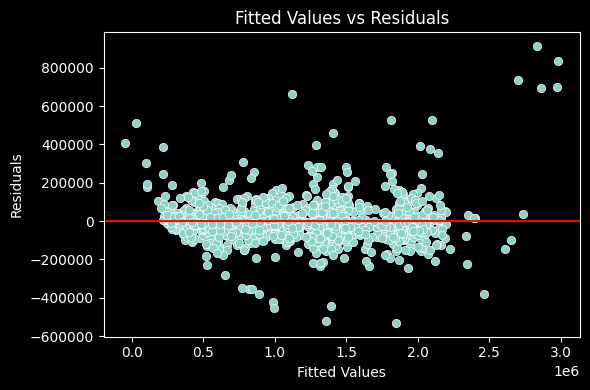

In [46]:
# create a scatterplot with the fitted values from the model and the residuals.
plt.figure(figsize=(6,4))
ax = sns.scatterplot(x=champion_pred, y=champion_residuals)
ax.set_xlabel("Fitted Values")
ax.set_ylabel("Residuals")
ax.set_title("Fitted Values vs Residuals")
ax.axhline(color='red')

plt.tight_layout()
plt.show()

Variance fitted values are similarly distributed (upper and below y=0), validating that the assumption is meet

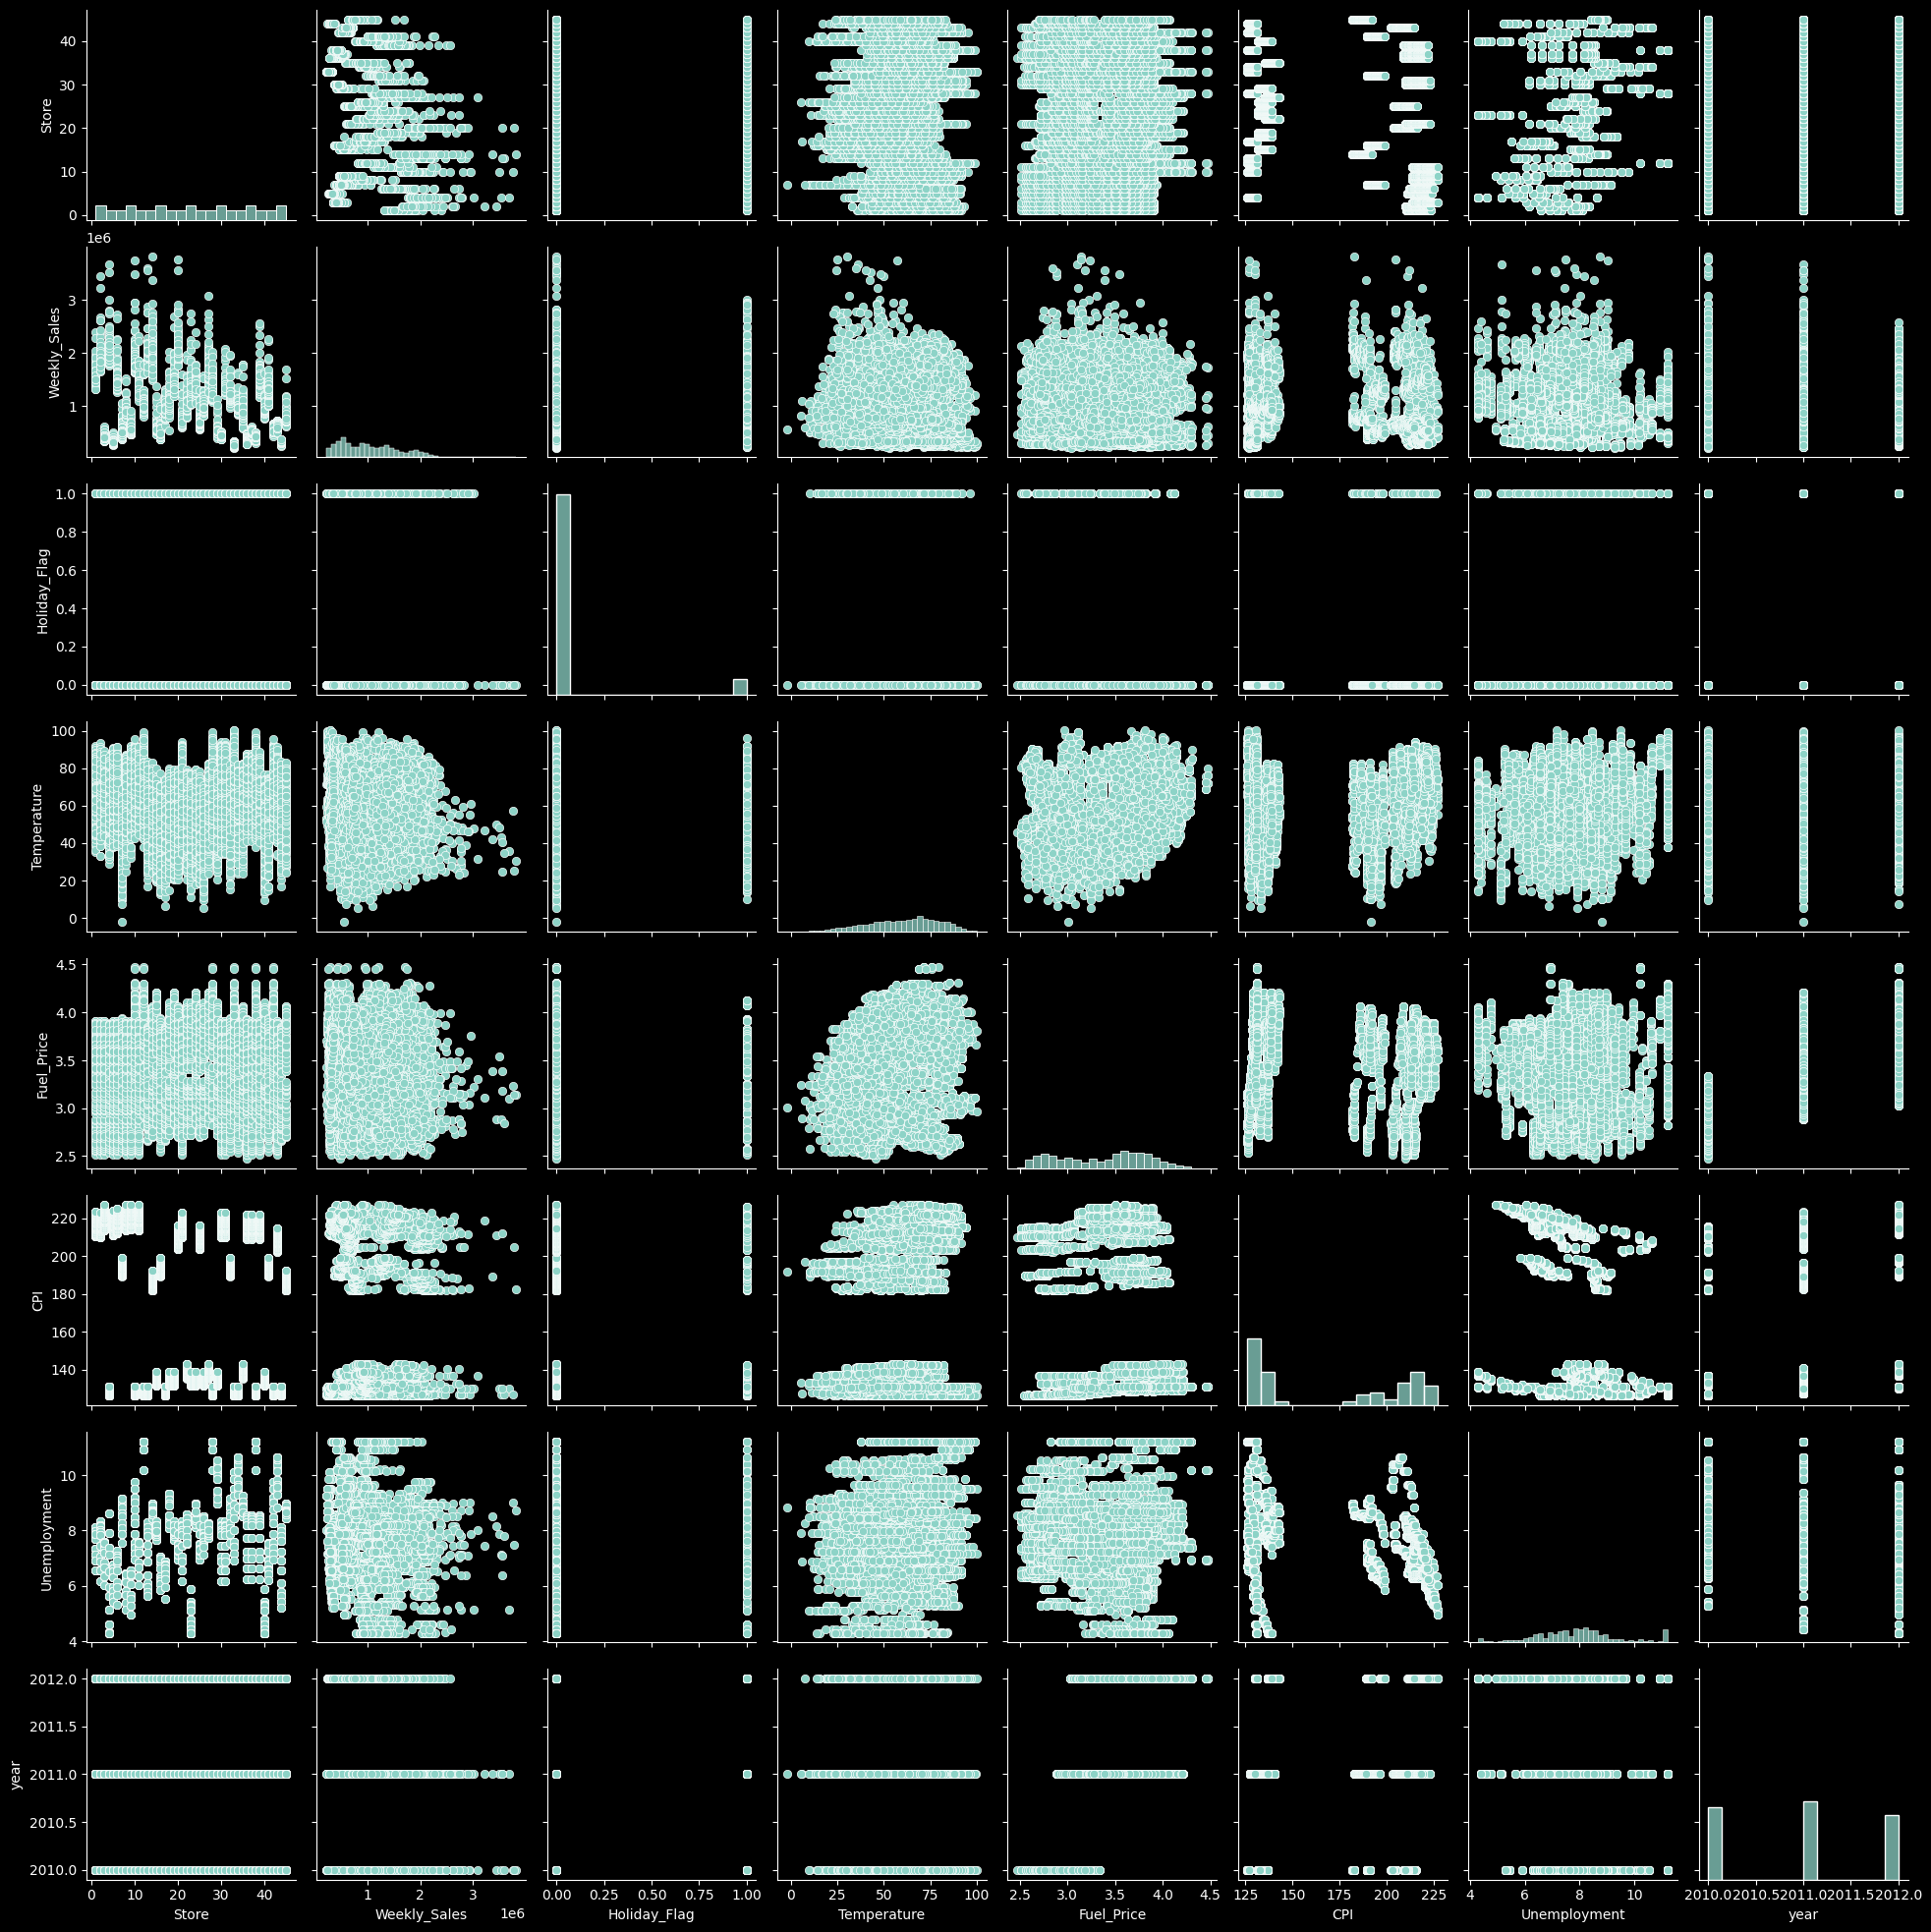

In [50]:
# checking no multicollinearity assumption
sns.pairplot(walmart.iloc[:,:-3])
plt.show()

In [ ]:
regressor_names = ["Linear Regression", "Polynomial Regression", "Ridge Regression", "Lasso Regression", 
                   "Elastic Net Regression", "Decision Tree Regression", "Random Forest Regression", 
                   "Boosted Tree Regression", "Neural Network Regression", "Support Vector Regression", 
                   "K-Nearest Neighbour Regression", "Spline Regression"]